In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from pymystem3 import Mystem
from string import punctuation
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams

!pip install swifter
import swifter
from tqdm import tqdm

import numpy as np
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 647 kB 5.1 MB/s 
     |████████████████████████████████| 280 kB 51.2 MB/s 
     |████████████████████████████████| 136 kB 43.3 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=b7fa5cdd508a24c9193d81361c3854861fe53e30edc9eaefe7d11e6f177460b6
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
df = pd.read_csv('without_last_two_weeks.csv', index_col=0, parse_dates=['workStartDate'])
df.head()

,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,address,specialityId,year,day,lemmatized_description,month,city,district,territory,postal
7375,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.816065,37.458660,инженер-строительством,Контроль объемов и качества выполненных работ ...,"Россия, Москва, Волоколамское шоссе, 63",af02837b-7814-43d0-97ab-48b2b9813120,2021,4,контроль объем и качество выполнять работа под...,4,Москва,МО Покровское-Стрешнево,Центральный федеральный округ,125367.0
1951,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.765458,37.796517,Электрик,Организация выполнения электротехнических рабо...,"Россия, Москва, шоссе Энтузиастов, 86",6c183c81-cdb8-4d9c-a48f-877a516a93bc,2021,4,организация выполнение электротехнический рабо...,4,Москва,МО Перово,Центральный федеральный округ,111123.0
546,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,Укладка пеноблоков\nМеханизированным способом\...,"Россия, Москва, Инновационный центр Сколково, ...",256464cf-39f5-405c-a006-6b1505f6a961,2021,4,укладка пеноблок механизировать способ доставл...,4,Москва,МО Можайский,Центральный федеральный округ,143026.0
9667,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.816065,37.458660,Руководил бригадой строителей,Управление бригадой 30 человек (923) 108-89-96,"Россия, Москва, Волоколамское шоссе, 63",7ce33ae6-7b86-48e8-9698-7650b3cbe42e,2021,4,управление бригада человек,4,Москва,МО Покровское-Стрешнево,Центральный федеральный округ,125367.0
7381,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.685041,37.350683,Геодезист,"Выполнение комплекса геодезических работ, обес...","Россия, Москва, Инновационный центр Сколково, ...",889bf632-b7e6-4c9e-887d-fa06acc47f10,2021,4,выполнение комплекс геодезический работа обесп...,4,Москва,МО Можайский,Центральный федеральный округ,143026.0


In [ ]:
df['year'] = df['workStartDate'].dt.year
df['day'] = df['workStartDate'].dt.month

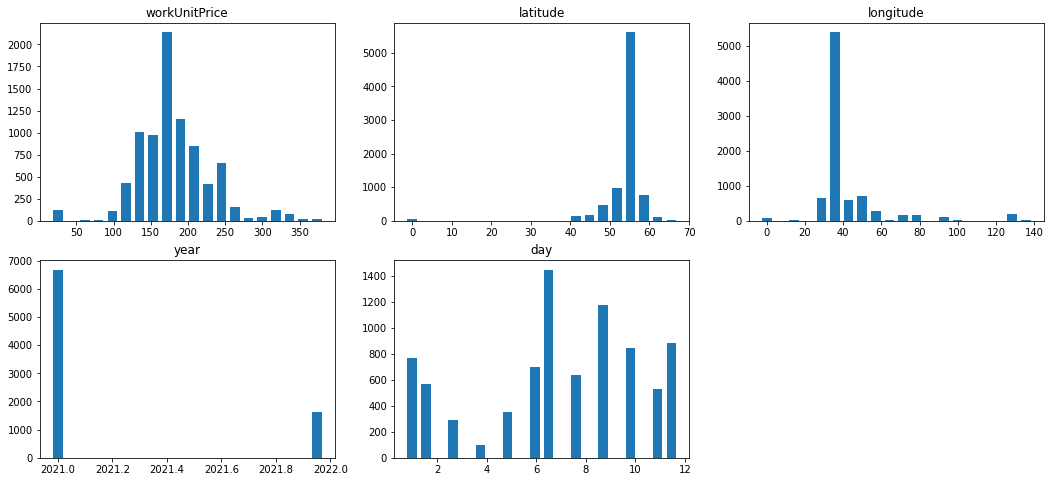

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': df['workUnitPrice'].dropna(),
    'latitude': df['latitude'].dropna(),
    'longitude': df['longitude'].dropna(),
    'year': df['year'].dropna(),
    'day': df['day'].dropna()
})

In [ ]:
df['workUnitPrice'].min()
#df['workUnitPrice'].max()

25.0

In [ ]:
!pip install pymorphy2
import pymorphy2
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import time

russian_stopwords = stopwords.words("russian")
lemma = pymorphy2.MorphAnalyzer()

#Код функции обработки текста:
def preprocess_text(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in russian_stopwords])
    punc_free = ''.join(ch for ch in stop_free if ch not in punctuation)
    text = " ".join([lemma.parse(word)[0].normal_form for word in punc_free.split(' ')])
    return text

df['lemmatized_description'] = df['description'].swifter.apply(preprocess_text)
df.head()

     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 10.2 MB/s 


Pandas Apply:   0%|          | 0/8313 [00:00<?, ?it/s]

,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,address,specialityId,year,day,lemmatized_description,month,city,district,territory,postal
7375,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.816065,37.458660,инженер-строительством,Контроль объемов и качества выполненных работ ...,"Россия, Москва, Волоколамское шоссе, 63",af02837b-7814-43d0-97ab-48b2b9813120,2021,4,контроль объём качество выполнить работа подря...,4,Москва,МО Покровское-Стрешнево,Центральный федеральный округ,125367.0
1951,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.765458,37.796517,Электрик,Организация выполнения электротехнических рабо...,"Россия, Москва, шоссе Энтузиастов, 86",6c183c81-cdb8-4d9c-a48f-877a516a93bc,2021,4,организация выполнение электротехнический рабо...,4,Москва,МО Перово,Центральный федеральный округ,111123.0
546,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,Укладка пеноблоков\nМеханизированным способом\...,"Россия, Москва, Инновационный центр Сколково, ...",256464cf-39f5-405c-a006-6b1505f6a961,2021,4,укладка пеноблок механизировать способ доставл...,4,Москва,МО Можайский,Центральный федеральный округ,143026.0
9667,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.816065,37.458660,Руководил бригадой строителей,Управление бригадой 30 человек (923) 108-89-96,"Россия, Москва, Волоколамское шоссе, 63",7ce33ae6-7b86-48e8-9698-7650b3cbe42e,2021,4,управление бригада 30 человек 923 1088996,4,Москва,МО Покровское-Стрешнево,Центральный федеральный округ,125367.0
7381,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.685041,37.350683,Геодезист,"Выполнение комплекса геодезических работ, обес...","Россия, Москва, Инновационный центр Сколково, ...",889bf632-b7e6-4c9e-887d-fa06acc47f10,2021,4,выполнение комплекс геодезический работа обесп...,4,Москва,МО Можайский,Центральный федеральный округ,143026.0


In [ ]:
df.to_csv('without_last_two_weeks.csv')

In [ ]:
russian_stopwords = stopwords.words("russian")

vectorizer = TfidfVectorizer(stop_words=russian_stopwords, token_pattern=u'(?ui)\\b\\w*[а-я]+\\w*\\b', ngram_range=(2,2))
matrix_tfidf = vectorizer.fit_transform(df['lemmatized_description'])

In [ ]:
top_words = pd.DataFrame(columns=df['specialityId'].unique())

def get_top_for_group(descriptions: pd.Series, group: str):
    global top_words
    if len(descriptions)<2 and len(descriptions.iloc[0].split())<2:
        return
    matrix_tfidf = vectorizer.fit_transform(descriptions)
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(matrix_tfidf.toarray()).flatten()[::-1]

    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    top_words[group] = pd.Series(top_n)

In [ ]:
for group in top_words.keys():
    descriptions = df[df['specialityId']==group]['lemmatized_description']
    get_top_for_group(descriptions, group)

top_words

,af02837b-7814-43d0-97ab-48b2b9813120,6c183c81-cdb8-4d9c-a48f-877a516a93bc,256464cf-39f5-405c-a006-6b1505f6a961,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,889bf632-b7e6-4c9e-887d-fa06acc47f10,4f1a1b97-21c8-4f64-badf-ab4760eebaed,623c4e3e-5971-43f7-895a-c9e68abf9ede,122997d2-780f-4103-ac0a-4178dd479934,d55e4589-beac-4964-bd69-d7efff11290c,708435b6-3756-4edd-91a8-6275c55a5199,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,требование нормативный,электротехнический работа,цементный молоко,торговый зал,точный соответствие,товар торговый,товар мерчандайзинг,электронный площадка,товар предпродажный,товар мерчандайзинг,...,сборка букет,обработка заказ,центр дневный,час наш,система видеонаблюдение,яндекс тд,торговый зал,электроинструмент строительный,февраль время,NaN
1,соответствие выполнять,организация проведение,пеноблок механизировать,работник торговый,соответствие проект,торговый зал,подготовка товар,функционал электронный,предпродажный подготовка,подготовка товар,...,заказ день,заказ день,торговый центр,звонок час,работа система,нуля обеспечение,выкладка торговый,строительный работа,требование размер,NaN
2,работа требование,выполнение электротехнический,доставляться техника,управление бригада,работа обеспечивать,выкладка товар,товар предпродажный,услуга направить,товар мерчандайзинг,предпродажный подготовка,...,букет заказ,выкладка товар,проверка qrкод,наш сотрудник,накладный контроль,маркетплейс формирование,торговый зал,работа работа,размер нога,NaN
3,работа подрядный,выполнить работа,захватка ручной,товар прилавок,проект геометрический,этикетка скомпановать,предпродажный подготовка,поручение заказчик,подготовка товар,товар предпродажный,...,сборка букет,обработка заказ,дневный график,сотрудник обрабатывать,контроль накладный,маркетплейс яндекс,выкладка торговый,работа электроинструмент,примерка отбор,NaN
4,проектный документация,исполнительный документация,каждый смотреть,выкладка товар,обеспечивать точный,мир фототчёт,выкладка товар,оказать комплекс,выкладка товар,выкладка товар,...,заказ день,заказ день,qrкод торговый,обрабатывать звонок,контроль выходавход,маркировка контроль,NaN,слесарный работа,приглашать девушка,NaN
5,подрядный организация,контроль выполнение,куб оплата,бригада человек,комплекс геодезический,навешивание вещь,эп порядок,обязываться поручение,кассир постоянка,поддержание порядок,...,букет заказ,выкладка товар,центр дневный,рубль звонок,выходавход работа,наименование описание,NaN,технический осмотр,отбор февраль,NaN
6,организация контроль,объект контроль,м3 объём,торговый зал,геометрический параметр,наведение порядок,покупатель выставление,направить консультирование,кондитерский продукция,зал выкладка,...,сборка букет,обработка заказ,торговый центр,ь курировать,торговый зал,наполнение карточка,NaN,прибор запорный,отбор обувной,NaN
7,объём качество,организация выполнение,месяц старт,работник торговый,геодезический работа,мытьё полка,подсорт товар,консультирование клиент,набчелны ул,магазин модис,...,заказ день,заказ день,проверка qrкод,поддержка ь,охрана торговый,необходимый склад,NaN,арматура тд,обязательный требование,NaN
8,нормативный проектный,оформление технический,механизировать способ,управление бригада,выполнение комплекс,мытьё оборудование,поддержание порядок,комплекс услуга,молочный товар,мерчендайзинг поддержание,...,букет заказ,выкладка товар,дневный график,звонок загрузка,система видеонаблюдение,новый площадка,NaN,вентиляция пожаротушение,обувной коллекция,NaN
9,контроль соответствие,учёт выполнить,мм стоимость,товар прилавок,точный соответствие,мужчина постоянка,подготовкаработа тсд,клиент заказчик,молочный отдел,модис предпродажный,...,сборка букет,выкладка товар,qrкод торговы

In [ ]:
def count_words_from_top(description, top_words):
    tokens = nltk.word_tokenize(description)
    bigram = list(ngrams(tokens, 2)) 
    count = 0
    for token in bigram:
        if ' '.join(token) in list(top_words):
            count += 1
    return count

for speciality in df['specialityId'].unique():
    df[speciality] = df['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

df.head()

,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,address,specialityId,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
7375,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.816065,37.458660,инженер-строительством,Контроль объемов и качества выполненных работ ...,"Россия, Москва, Волоколамское шоссе, 63",af02837b-7814-43d0-97ab-48b2b9813120,...,0,0,0,0,0,0,0,0,0,0
1951,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.765458,37.796517,Электрик,Организация выполнения электротехнических рабо...,"Россия, Москва, шоссе Энтузиастов, 86",6c183c81-cdb8-4d9c-a48f-877a516a93bc,...,0,0,0,0,0,0,0,0,0,0
546,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,Укладка пеноблоков\nМеханизированным способом\...,"Россия, Москва, Инновационный центр Сколково, ...",256464cf-39f5-405c-a006-6b1505f6a961,...,0,0,0,0,0,0,0,0,0,0
9667,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.816065,37.458660,Руководил бригадой строителей,Управление бригадой 30 человек (923) 108-89-96,"Россия, Москва, Волоколамское шоссе, 63",7ce33ae6-7b86-48e8-9698-7650b3cbe42e,...,0,0,0,0,0,0,0,0,0,0
7381,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-04-01,55.685041,37.350683,Геодезист,"Выполнение комплекса геодезических работ, обес...","Россия, Москва, Инновационный центр Сколково, ...",889bf632-b7e6-4c9e-887d-fa06acc47f10,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['02aa72e5-25f4-4431-b9ae-c0e884b9eec3'].value_counts()

0    8304
3       5
1       4
Name: 02aa72e5-25f4-4431-b9ae-c0e884b9eec3, dtype: int64

In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X = df[columns]
y = df['workUnitPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
y_pred_s = pd.Series(y_pred)
df_s = pd.concat([y_test, X_test], axis=1)

df_s = df_s.merge(y_pred_s.rename('y_pred'), left_index=True, right_index=True)

In [ ]:
df_s.to_csv('predict.csv')

In [ ]:
!pip3 install catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
RANDOM_SEED = 42
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric='R2',
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


     |████████████████████████████████| 76.6 MB 49 kB/s 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<BarContainer object of 43 artists>

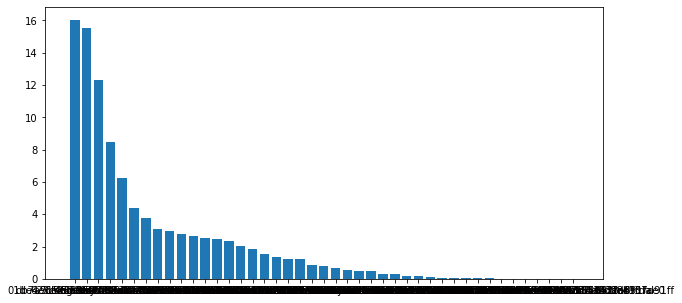

In [ ]:
skl_wine_imp = model.get_feature_importance(prettified=True)


plt.bar(skl_wine_imp['Feature Id'], skl_wine_imp['Importances'])

In [ ]:
skl_wine_imp

,Feature Id,Importances
0,longitude,16.029803
1,day,15.510258
2,latitude,12.327294
3,01de4e66-5d0f-49f9-bddc-1f708c87a6d6,8.451620
4,db7a9156-36ae-408a-a5df-955ab8738b57,6.218467
5,623c4e3e-5971-43f7-895a-c9e68abf9ede,4.382550
6,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,3.789594
7,4f1a1b97-21c8-4f64-badf-ab4760eebaed,3.073294
8,860ba591-abee-4293-a47c-ce1a8e36e844,2.970140
9,e84fd293-a45f-4c7b-91ec-7c92f9e1adcc,2.783354


In [ ]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.829673466248738

In [ ]:
len(y_pred)

2494

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.06895367949082012

In [ ]:
m = CatBoostRegressor()

In [ ]:
params = {'iterations': [500, 1000, 5000, 100],
          'max_depth': [4, 6, 10],
          #'loss_function': ['RMSE', 'MultiRMSE', 'SurvivalAft', 'MAE', 'Quantile', 'LogLinQuantile', 'Poisson', 'MAPE'],
          #'l2_leaf_reg': np.logspace(-20, -19, 3),
          #'leaf_estimation_iterations': [10],
          #'eval_metric': ['MAPE'],
          #'use_best_model': ['True'],
          #'logging_level':['Silent'],
          'random_seed': [42, 50]
         }
cb = GridSearchCV(m, params,  scoring='r2')
cb.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 48.3140348	total: 17.5ms	remaining: 1m 27s
1:	learn: 48.0252404	total: 33.7ms	remaining: 1m 24s
2:	learn: 47.7694039	total: 45.5ms	remaining: 1m 15s
3:	learn: 47.4948007	total: 55.9ms	remaining: 1m 9s
4:	learn: 47.2285493	total: 74.1ms	remaining: 1m 14s
5:	learn: 46.9454606	total: 85.6ms	remaining: 1m 11s
6:	learn: 46.6883536	total: 97.1ms	remaining: 1m 9s
7:	learn: 46.4145692	total: 108ms	remaining: 1m 7s
8:	learn: 46.1222149	total: 119ms	remaining: 1m 5s
9:	learn: 45.9081225	total: 130ms	remaining: 1m 4s
10:	learn: 45.6622463	total: 140ms	remaining: 1m 3s
11:	learn: 45.4682009	total: 151ms	remaining: 1m 2s
12:	learn: 45.2168745	total: 163ms	remaining: 1m 2s
13:	learn: 44.9750910	total: 174ms	remaining: 1m 1s
14:	learn: 44.7446280	total: 185ms	remaining: 1m 1s
15:	learn: 44.5680299	total: 196ms	remaining: 1m 1s
16:	learn: 44.3382417	total: 207ms	remaining: 1m
17:	learn: 44.1547436	total: 218ms	remaining: 1m


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f1a07566650>,
             param_grid={'iterations': [500, 1000, 5000, 100],
                         'max_depth': [4, 6, 10], 'random_seed': [42, 50]},
             scoring='r2')

In [ ]:
best_param = cb.best_params_
best_param

{'iterations': 5000, 'max_depth': 10, 'random_seed': 42}

In [ ]:
y_pred = cb.best_estimator_.predict(X_test)
r2_score(y_test, y_pred)

0.8337523957092201

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.06405528495812346

# Prediction for test file19042022

In [ ]:
data_prod = pd.read_csv('test_data_19042022.csv', parse_dates=['workStartDate'])
data_prod

,Unnamed: 0,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,workStartDate,workEndDate,...,contractorRecruitmentRequired,contractorRecruitmentRequiredUpdateDatetime,tariffScaleId,categorySpecialityId,minCommission,threshold,clientId-2,objectId-2,longitude,latitude
0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,2022-04-04,2022-04-10,...,False,2022-04-13 09:00:13.456708,NaN,NaN,NaN,NaN,8aeee516-fe8b-41cc-8a84-1005982fd998,6f4621aa-90a3-4088-804c-84aead1d1873,37.300988,55.948760
1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-13,2022-04-13,...,False,2022-04-13 09:27:45.335894,NaN,NaN,NaN,NaN,e09cb55f-b62d-4acc-8647-6a65ec5ea937,e851dfce-f649-465f-8650-b7bc9544035a,55.102806,51.771969
2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,2022-03-31,2022-03-31,...,False,2022-03-31 08:38:09.097505,NaN,NaN,NaN,NaN,ba5f2689-87df-483c-a115-942e1abf130a,6b2a2d79-6177-4234-9d50-f7c03b95c24c,37.790353,55.795991
3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-11,2022-04-15,...,False,2022-04-10 13:20:07.175028,a2b6bce9-b8a2-420f-8d57-4fe04d343c9d,NaN,NaN,NaN,e09cb55f-b62d-4acc-8647-6a65ec5ea937,0670a2f7-531c-44da-ae97-b194266d1eed,56.000873,54.720979
4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,2022-04-12,2022-04-13,...,False,2022-04-12 12:29:35.996603,NaN,NaN,NaN,NaN,c9597816-a374-41dc-be3e-b052b25c5582,44d948d4-6a65-482f-9ffa-bc0480e519e6,33.095247,68.914481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,17764,795ac18f-a980-4b2d-b783-aa3948dac113,341f07d4-72d8-4f7b-acb2-bc18c258d7b4,8a4273ac-0842-45d2-bd09-c2ce983a4ff9,a00179f9-3afc-45cb-a504-848f4cdfabdc,NaN,Выполнение услуг по перезонированию магазина У...,NaN,2022-04-20,2022-04-20,...,False,2022-04-19 11:45:38.779834,NaN,NaN,NaN,NaN,795ac18f-a980-4b2d-b783-aa3948dac113,a00179f9-3afc-45cb-a504-848f4cdfabdc,37.307142,55.625948
395,17780,ead8733b-7e34-44f1-ad6b-efb99a245d6c,18899650-d705-4c78-825d-551982eb3129,b3433d10-e270-493c-9dd7-bdb38e1be34c,a0168d70-797b-4cda-bc2d-d919caa415c9,NaN,"выкладка товара , печать и установка ценников",NaN,2022-03-01,2022-03-31,...,False,2022-04-19 11:49:39.332543,NaN,NaN,NaN,NaN,ead8733b-7e34-44f1-ad6b-efb99a245d6c,a0168d70-797b-4cda-bc2d-d919caa415c9,76.647623,66.081150
396,17788,c9597816-a374-41dc-be3e-b052b25c5582,9d24899e-48da-4e09-9a84-3c9d4af7f6eb,fb632cca-d1ab-490a-99e4-2790ccc91eeb,370457ee-43b7-4b4d-98b7-317db85070f6,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-01,2022-04-30,...,False,2022-04-02 07:19:06.08261,NaN,NaN,NaN,NaN,c9597816-a374-41dc-be3e-b052b25c5582,370457ee-43b7-4b4d-98b7-317db85070f6,37.707098,55.747363
397,17792,c9597816-a374-41dc-be3e-b052b25c5582,33501362-7951-4822-a499-ce49ba9bb023,064c915c-c159-49fc-a81a-ea0781783c85,f7af72fa-95ab-44c5-b82a-ca497c65fda8,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-19,2022-04-30,...,False,2022-04-19 12:57:02.37009,NaN,NaN,NaN,NaN,c9597816-a374-41dc-be3e-b052b25c5582,f7af72fa-95ab-44c5-b82a-ca497c65fda8,37.682617,55.790397


In [ ]:
data_prod['year'] = data_prod['workStartDate'].dt.year
data_prod['day'] = data_prod['workStartDate'].dt.month

In [ ]:
IQR1 = 24.5
IQR2 = 412.5

In [ ]:
#y25 = data_prod['workUnitPrice'].quantile(q=0.25)
#y75 = data_prod['workUnitPrice'].quantile(q=0.75)
#IQR1 = y25 - 1.5*(y75-y25)
#IQR2 = y75 + 1.5*(y75-y25)

In [ ]:
data_prod = data_prod[(data_prod['workUnitPrice']>IQR1) & (data_prod['workUnitPrice']<IQR2)]

In [ ]:
#data_prod['publicationDate'] = pd.to_datetime(data_prod['publicationDate'], dayfirst=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#data_prod['publicationDate']=pd.to_datetime(data_prod['publicationDate']).dt.strftime('%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


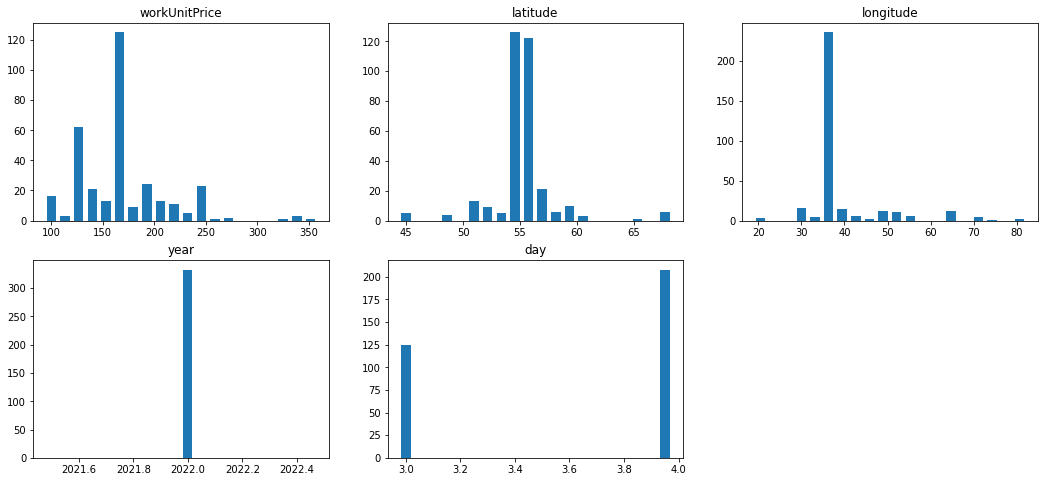

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': data_prod['workUnitPrice'].dropna(),
    'latitude': data_prod['latitude'].dropna(),
    'longitude': data_prod['longitude'].dropna(),
    'year': data_prod['year'].dropna(),
    'day': data_prod['day'].dropna()
})

In [ ]:
data_prod['lemmatized_description'] = data_prod['description'].swifter.apply(preprocess_text)
data_prod.head()

Pandas Apply:   0%|          | 0/333 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,workStartDate,workEndDate,...,categorySpecialityId,minCommission,threshold,clientId-2,objectId-2,longitude,latitude,year,day,lemmatized_description
0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,2022-04-04,2022-04-10,...,NaN,NaN,NaN,8aeee516-fe8b-41cc-8a84-1005982fd998,6f4621aa-90a3-4088-804c-84aead1d1873,37.300988,55.948760,2022,4,выкладка товар
1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-13,2022-04-13,...,NaN,NaN,NaN,e09cb55f-b62d-4acc-8647-6a65ec5ea937,e851dfce-f649-465f-8650-b7bc9544035a,55.102806,51.771969,2022,4,проверка соответствие наличие ценник пополнени...
2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,2022-03-31,2022-03-31,...,NaN,NaN,NaN,ba5f2689-87df-483c-a115-942e1abf130a,6b2a2d79-6177-4234-9d50-f7c03b95c24c,37.790353,55.795991,2022,3,выкладка товар прилавок
3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-11,2022-04-15,...,NaN,NaN,NaN,e09cb55f-b62d-4acc-8647-6a65ec5ea937,0670a2f7-531c-44da-ae97-b194266d1eed,56.000873,54.720979,2022,4,проверка соответствие наличие ценник пополнени...
4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,2022-04-12,2022-04-13,...,NaN,NaN,NaN,c9597816-a374-41dc-be3e-b052b25c5582,44d948d4-6a65-482f-9ffa-bc0480e519e6,33.095247,68.914481,2022,4,осуществить погрузка разгрузка товар


In [ ]:
for speciality in top_words.keys():
    data_prod[speciality] = data_prod['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

data_prod.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,workStartDate,workEndDate,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,2022-04-04,2022-04-10,...,0,1,0,0,0,0,0,0,0,0
1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-13,2022-04-13,...,0,0,0,0,2,0,2,0,0,0
2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,2022-03-31,2022-03-31,...,0,1,0,0,0,0,0,0,0,0
3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,2022-04-11,2022-04-15,...,0,0,0,0,2,0,2,0,0,0
4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,2022-04-12,2022-04-13,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X = data_prod[columns]
y = data_prod['workUnitPrice']

In [ ]:
y_pred = model.predict(X)
r2_score(y, y_pred)

0.7763387823345782

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.07238151999863562

In [ ]:
y_pred = cb.best_estimator_.predict(X)
r2_score(y, y_pred)

0.7787902057053923

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.06122007079827096

**Первая неделя**

In [ ]:
data_prod['publicationDate'].max()

'2022-04-19 12:57:14.294707'

In [ ]:
#import datetime

#startdate = datetime.datetime.strptime('2022-03-24', "%Y-%m-%d").date()
#enddate = datetime.datetime.strptime('2011-03-27', "%Y-%m-%d").date()
df_1 = data_prod.query(("publicationDate >= '2022-03-24'") and ("publicationDate <= '2022-03-27'"))
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 52 to 306
Columns: 144 entries, Unnamed: 0 to fbdb0f85-1254-4820-b656-09ec907d91ff
dtypes: bool(20), datetime64[ns](1), float64(23), int64(45), object(55)
memory usage: 20.9+ KB


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X_1 = df_1[columns]
y_1 = df_1['workUnitPrice']

In [ ]:
y_pred1 = model.predict(X_1)
r2_score(y_1, y_pred1)

0.9186633671129301

In [ ]:
mean_absolute_percentage_error(y_1, y_pred1)

0.07483775224450036

**Вторая неделя**

In [ ]:
df_2 = data_prod.query(("publicationDate >= '2022-03-28'") and ("publicationDate <= '2022-04-03'"))
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 2 to 396
Columns: 144 entries, Unnamed: 0 to fbdb0f85-1254-4820-b656-09ec907d91ff
dtypes: bool(20), datetime64[ns](1), float64(23), int64(45), object(55)
memory usage: 104.6+ KB


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X_2 = df_2[columns]
y_2 = df_2['workUnitPrice']

In [ ]:
y_pred2 = model.predict(X_2)
r2_score(y_2, y_pred2)

0.767262487388607

In [ ]:
mean_absolute_percentage_error(y_2, y_pred2)

0.07478006618643677

**Третья неделя**

In [ ]:
df_3 = data_prod.query(("publicationDate >= '2022-04-04'") and ("publicationDate <= '2022-04-10'"))
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 2 to 396
Columns: 144 entries, Unnamed: 0 to fbdb0f85-1254-4820-b656-09ec907d91ff
dtypes: bool(20), datetime64[ns](1), float64(23), int64(45), object(55)
memory usage: 175.3+ KB


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X_3 = df_3[columns]
y_3 = df_3['workUnitPrice']

In [ ]:
y_pred3 = model.predict(X_3)
r2_score(y_3, y_pred3)

0.8029421992276702

In [ ]:
mean_absolute_percentage_error(y_3, y_pred3)

0.07275707458899318

**Четвертая неделя**

In [ ]:
df_4 = data_prod.query(("publicationDate >= '2022-04-11'") and ("publicationDate <= '2022-04-17'"))
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 396
Columns: 144 entries, Unnamed: 0 to fbdb0f85-1254-4820-b656-09ec907d91ff
dtypes: bool(20), datetime64[ns](1), float64(23), int64(45), object(55)
memory usage: 297.8+ KB


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X_4 = df_4[columns]
y_4 = df_4['workUnitPrice']

In [ ]:
y_pred4 = model.predict(X_4)
r2_score(y_4, y_pred4)

0.7723719364772328

In [ ]:
mean_absolute_percentage_error(y_4, y_pred4)

0.07504261504581418

**Пятая неделя**

In [ ]:
df_5 = data_prod.query(("publicationDate >= '2022-04-18'") and ("publicationDate <= '2022-04-19'"))
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 396
Columns: 144 entries, Unnamed: 0 to fbdb0f85-1254-4820-b656-09ec907d91ff
dtypes: bool(20), datetime64[ns](1), float64(23), int64(45), object(55)
memory usage: 318.8+ KB


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X_5 = df_5[columns]
y_5 = df_5['workUnitPrice']

In [ ]:
y_pred5 = model.predict(X_5)
r2_score(y_5, y_pred5)

0.7746161851645051

In [ ]:
mean_absolute_percentage_error(y_5, y_pred5)

0.07307916019967595

# Prediction for test file

In [ ]:
test = pd.read_csv('last_two_weeks.csv', index_col=0, parse_dates=['workStartDate'])

In [ ]:
test['year'] = test['workStartDate'].dt.year
test['day'] = test['workStartDate'].dt.month

In [ ]:
test['lemmatized_description'] = test['description'].swifter.apply(preprocess_text)
test.head()

Pandas Apply:   0%|          | 0/147 [00:00<?, ?it/s]

,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,address,specialityId,year,day,lemmatized_description
6607,77a1fabf-9b66-4f54-9e06-bdaf712dd73b,HOUR,220.22,2022-03-25,55.901783,37.548411,выкладка товара,выкладка товара в торговом зале,"г Москва, Дмитровское шоссе, д 116Д",4f1a1b97-21c8-4f64-badf-ab4760eebaed,2022,3,выкладка товар торговый зал
6999,77a1fabf-9b66-4f54-9e06-bdaf712dd73b,HOUR,100.00,2022-03-25,55.754047,37.620405,выкладка товара,выкладка товара в торговом зале,г Москва,4f1a1b97-21c8-4f64-badf-ab4760eebaed,2022,3,выкладка товар торговый зал
7266,0cefa3f8-7a59-471c-980d-3ee214576777,HOUR,211.65,2022-03-25,55.658940,52.271159,Продавец,Оказание услуг для магазина по выкладке товара,"423820, РТ, г. Набережные Челны, ул. Магистрал...",d55e4589-beac-4964-bd69-d7efff11290c,2022,3,оказание услуга магазин выкладка товар
7286,77a1fabf-9b66-4f54-9e06-bdaf712dd73b,HOUR,197.88,2022-03-25,55.864172,37.551241,выкладка товара,выкладка товара в торговом зале,"г Москва, Дмитровское шоссе, д 80",4f1a1b97-21c8-4f64-badf-ab4760eebaed,2022,3,выкладка товар торговый зал
6723,795ac18f-a980-4b2d-b783-aa3948dac113,HOUR,230.00,2022-03-25,55.543653,37.531983,Выполнение услуг по разгрузке и помощи в откры...,Помощь в открытии магазина,"г Москва, ул Горчакова, д 11",01de4e66-5d0f-49f9-bddc-1f708c87a6d6,2022,3,помощь открытие магазин


In [ ]:
test.to_csv('last_two_weeks.csv')

In [ ]:
for speciality in top_words.keys():
    test[speciality] = test['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

test.head()

,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,description,address,specialityId,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
6607,77a1fabf-9b66-4f54-9e06-bdaf712dd73b,HOUR,220.22,2022-03-25,55.901783,37.548411,выкладка товара,выкладка товара в торговом зале,"г Москва, Дмитровское шоссе, д 116Д",4f1a1b97-21c8-4f64-badf-ab4760eebaed,...,0,1,0,0,1,0,1,0,0,0
6999,77a1fabf-9b66-4f54-9e06-bdaf712dd73b,HOUR,100.00,2022-03-25,55.754047,37.620405,выкладка товара,выкладка товара в торговом зале,г Москва,4f1a1b97-21c8-4f64-badf-ab4760eebaed,...,0,1,0,0,1,0,1,0,0,0
7266,0cefa3f8-7a59-471c-980d-3ee214576777,HOUR,211.65,2022-03-25,55.658940,52.271159,Продавец,Оказание услуг для магазина по выкладке товара,"423820, РТ, г. Набережные Челны, ул. Магистрал...",d55e4589-beac-4964-bd69-d7efff11290c,...,0,1,0,0,0,0,0,0,0,0
7286,77a1fabf-9b66-4f54-9e06-bdaf712dd73b,HOUR,197.88,2022-03-25,55.864172,37.551241,выкладка товара,выкладка товара в торговом зале,"г Москва, Дмитровское шоссе, д 80",4f1a1b97-21c8-4f64-badf-ab4760eebaed,...,0,1,0,0,1,0,1,0,0,0
6723,795ac18f-a980-4b2d-b783-aa3948dac113,HOUR,230.00,2022-03-25,55.543653,37.531983,Выполнение услуг по разгрузке и помощи в откры...,Помощь в открытии магазина,"г Москва, ул Горчакова, д 11",01de4e66-5d0f-49f9-bddc-1f708c87a6d6,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'day', 'latitude', 'longitude']
X = test[columns]
y = test['workUnitPrice']

In [ ]:
y_pred = model.predict(X)
r2_score(y, y_pred)

0.8653609688574073

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.07802744706992398

In [ ]:
y_pred = cb.best_estimator_.predict(X)
r2_score(y, y_pred)

0.9128991350107829

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.060151425087893104